# Reconstruccion testing

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

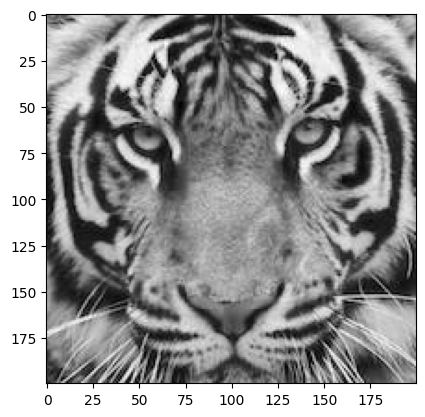

In [3]:
img = cv2.imread('g_tiger.jpg',0)

plt.imshow(img,cmap='gray')


## Generacion corriente I

Para generar las corrientes $I(x,y)$ se utiliza el kernel de convolución $D(x,y)$ el cual se define como:

$$ D(x,y) = \frac{1}{2\pi \sigma^{2}_{c}} \cdot e^{-\frac{x^{2}+y^{2}}{2\sigma_{c}^{2}}} - \frac{1}{2\pi \sigma^{2}_{s}} \cdot e^{-\frac{x^{2}+y^{2}}{2\sigma_{s}^{2}}} $$

Se selecciona un tamaño de $3 \times 3$ para el Kernel, con un strid de 1. Note que $D(x,y)$ puede ser interpretado como una diferencia de Gaussianas. 

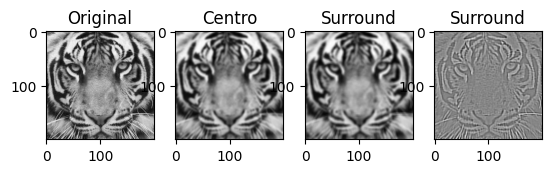

Center shape: (200, 200)
Surround shape: (200, 200)


In [14]:
img = img.astype(np.float32)

sigma_c1 = 1.5
sigma_s1 = 3

kernel_size = 5

center = cv2.GaussianBlur(img, (kernel_size,kernel_size), sigma_c1)
surround = cv2.GaussianBlur(img, (kernel_size,kernel_size), sigma_s1)
DoG = center - surround

fig, axs = plt.subplots(1,4)

# Original
axs[0].imshow(img,cmap='gray')
axs[0].set_title('Original')
# Center 
axs[1].imshow(center, cmap='gray')
axs[1].set_title('Centro')
#Surround 
axs[2].imshow(surround, cmap='gray')
axs[2].set_title('Surround')
#DoG
axs[3].imshow(DoG, cmap='gray')
axs[3].set_title('Surround')

plt.show()

print('Center shape: {}'.format(center.shape))
print('Surround shape: {}'.format(surround.shape))